In [1]:
import pandas as pd
import numpy as np
from data.utils import ts_stats
from models.utils import create_val_ids, create_sequences, accumulate_sequences
from sklearn.preprocessing import LabelEncoder


%load_ext autoreload
%autoreload 2

In [2]:
df_d = pd.read_csv("../data/ts_d_m.csv", parse_dates=["date"])
df_nd = pd.read_csv("../data/ts_nd_m.csv", parse_dates=["date"])

ts_stats(df_d)
ts_stats(df_nd)

Número de TSs: 100
Largo Promedio por TS: 268.0
Promedio de Nulos por TS: 9.17
Número de TSs: 100
Largo Promedio por TS: 268.0
Promedio de Nulos por TS: 12.23


In [3]:
# val_ids = create_val_ids(df_d, n = 10)
# val_ids

In [4]:
def prepare_data(train_normal_only = False):
    if train_normal_only:
        return df_nd, pd.concat([df_d, df_nd])
    else:
        return pd.concat([df_d, df_nd]), None

train_df, val_df = prepare_data(train_normal_only = True)

In [5]:
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
import torch
import torch.nn as nn

pl.seed_everything(42, workers=True)

Global seed set to 42


42

In [6]:
class ReconstructionBasedDataset(Dataset):
    def __init__(self, df, interpolate = False, seq_len = 10, ts_id = "ts_id", vals = "ndvi", ids = "id"):
        self.df = df
        self.interpolate = interpolate
        self.seq_len = seq_len
        self.ts_id = ts_id
        self.vals = vals
        self.ids = ids

        if interpolate:
            self.df["ndvi"] = df.ndvi.interpolate()
        self.sequences, self.idxs = self.create_sequences(self.df, ts_id, vals, ids, seq_len)

    @staticmethod
    def create_sequences(df, ts_id:str, vals: str, ids: str, seq_len: int):

        uids = df[ts_id].unique()
        ts_id = df[ts_id].values
        values = df[vals].values
        ids = df[ids].values

        sequences = []
        idxs = []
        for id in uids:
            vals = values[ts_id == id]
            for i in range(len(vals)-seq_len+1):
                sequences.append(vals[i:i+seq_len])
                idxs.append(ids[i:i+seq_len])
                #idxs.append(id)

        return sequences, idxs

    def __len__(self): 
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype = torch.float)#, torch.tensor(self.idxs[idx])

In [7]:
class DataModule(pl.LightningDataModule):
    def __init__(self, 
                train_df,
                val_df = None,  
                interpolate = False, 
                seq_len = 10, 
                ts_id = "ts_id", 
                vals = "ndvi", 
                ids = "id",
                batch_size = 32, 
                nw = 8
                ):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.interpolate = interpolate
        self.seq_len = seq_len
        self.ts_id = ts_id
        self.vals = vals
        self.ids = ids
        self.batch_size = batch_size
        self.nw = nw

    def setup(self, stage = None): 
        self.train_dataset = ReconstructionBasedDataset(
            self.train_df, self.interpolate, self.seq_len, self.ts_id, self.vals, self.ids)
        
        if self.val_df is not None:
            self.val_dataset = ReconstructionBasedDataset(
                self.val_df, self.interpolate, self.seq_len, self.ts_id, self.vals, self.ids)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size = self.batch_size, num_workers = self.nw, pin_memory = True, shuffle=False)
    
    def test_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size = 1, num_workers = self.nw, pin_memory = True, shuffle=False)
    
    def predict_dataloader(self):
        if self.val_df is not None:
            return DataLoader(self.val_dataset,  batch_size = self.batch_size, num_workers = self.nw, pin_memory = True, shuffle=False)
        else:
            return DataLoader(self.train_dataset,  batch_size = self.batch_size, num_workers = self.nw, pin_memory = True, shuffle=False)


In [8]:
dm = DataModule(train_df, val_df, interpolate = True, seq_len = 10, batch_size = 32)
dm.setup()

In [9]:
class VanillaAE(nn.Module): 
    def __init__(self, enc_layers, dec_layers):
        super().__init__()
        try: 
            assert enc_layers[-1] == dec_layers[0]
        except AssertionError: 
            raise AssertionError("Last encoder layer must have the same number of nodes as the first decoder layer")

        self.encoder = self.create_layers(enc_layers)
        self.decoder = self.create_layers(dec_layers)[:-1]

    @staticmethod
    def create_layers(list):
        layers = []
        for i in range(len(list)-1):
            layers.append(nn.Linear(list[i], list[i+1]))
            layers.append(nn.ReLU())

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
# sample = torch.randn(4, 10)
# model = VanillaAE([10, 8, 6], [6, 8, 10])
# model(sample)

In [11]:
class ReconstructionBasedAD(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        # x, _ = batch
        x_hat = self.model(batch)
        loss = self.criterion(x_hat, batch)
        self.log('train_loss', loss,  prog_bar = True, logger = True)
        return loss

    def predict_step(self, batch, batch_idx):
        # x, idxs = batch
        pred_seq = self(batch)
        loss = self.criterion(pred_seq, batch)
        return (pred_seq - batch)**2 #, idxs
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-5)

In [12]:
seq_len = 10
NAME = 'VanillaAE_Non_Disturbed_Resample_m'
model = VanillaAE(enc_layers = [seq_len, 40, 20, 10], dec_layers = [10, 20, 40, seq_len])
anomaly_detector = ReconstructionBasedAD(model)
dm = DataModule(train_df, val_df, interpolate=True, seq_len=10, batch_size=32)

mc = ModelCheckpoint(
    dirpath = 'checkpoints',
    save_last = True,
    save_top_k = 1,
    verbose = True,
    monitor = 'train_loss', 
    mode = 'min'
    )

mc.CHECKPOINT_NAME_LAST = f'{NAME}-best-checkpoint'

In [13]:
trainer = pl.Trainer(max_epochs=30,
                    accelerator="gpu",
                    devices=1, 
                    callbacks=[mc], 
                    #progress_bar_refresh_rate=30, 
                    fast_dev_run=False,
                    # overfit_batches=1
                    )
trainer.fit(anomaly_detector, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/datacuber/Documents/MSDS/samsara_tesis/notebooks/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | model     | VanillaAE | 2.9 K 
1 | criterion | MSELoss   | 0     
----------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)


A Jupyter Widget

Epoch 0, global step 810: 'train_loss' reached 0.33297 (best 0.33297), saving model to '/home/datacuber/Documents/MSDS/samsara_tesis/notebooks/checkpoints/epoch=0-step=810-v2.ckpt' as top 1
Epoch 1, global step 1620: 'train_loss' reached 0.26406 (best 0.26406), saving model to '/home/datacuber/Documents/MSDS/samsara_tesis/notebooks/checkpoints/epoch=1-step=1620.ckpt' as top 1
Epoch 2, global step 2430: 'train_loss' reached 0.19201 (best 0.19201), saving model to '/home/datacuber/Documents/MSDS/samsara_tesis/notebooks/checkpoints/epoch=2-step=2430.ckpt' as top 1
Epoch 3, global step 3240: 'train_loss' reached 0.11785 (best 0.11785), saving model to '/home/datacuber/Documents/MSDS/samsara_tesis/notebooks/checkpoints/epoch=3-step=3240.ckpt' as top 1
Epoch 4, global step 4050: 'train_loss' reached 0.05183 (best 0.05183), saving model to '/home/datacuber/Documents/MSDS/samsara_tesis/notebooks/checkpoints/epoch=4-step=4050.ckpt' as top 1
Epoch 5, global step 4860: 'train_loss' reached 0.0166

In [14]:
val_errors = trainer.predict(model = anomaly_detector, dataloaders = dm.test_dataloader())
val_results = []
for item in val_errors:
    val_results.extend(item.cpu().numpy())
    
len(val_results)
acc_val_errors = accumulate_sequences(val_results, len_ts = 268, n_ts = train_df.ts_id.nunique(), seq_len=10)
acc_val_errors

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


A Jupyter Widget

array([0.01358749, 0.0292041 , 0.0320142 , ..., 0.01200821, 0.01009516,
       0.00112353])

In [15]:
acc_val_errors.shape, train_df.shape

((26800,), (26800, 5))

In [16]:
train_df["pred_loss"] = acc_val_errors
train_df.to_csv("../preds/train_preds_vanillaAE.csv", index = False)

## Thresholds

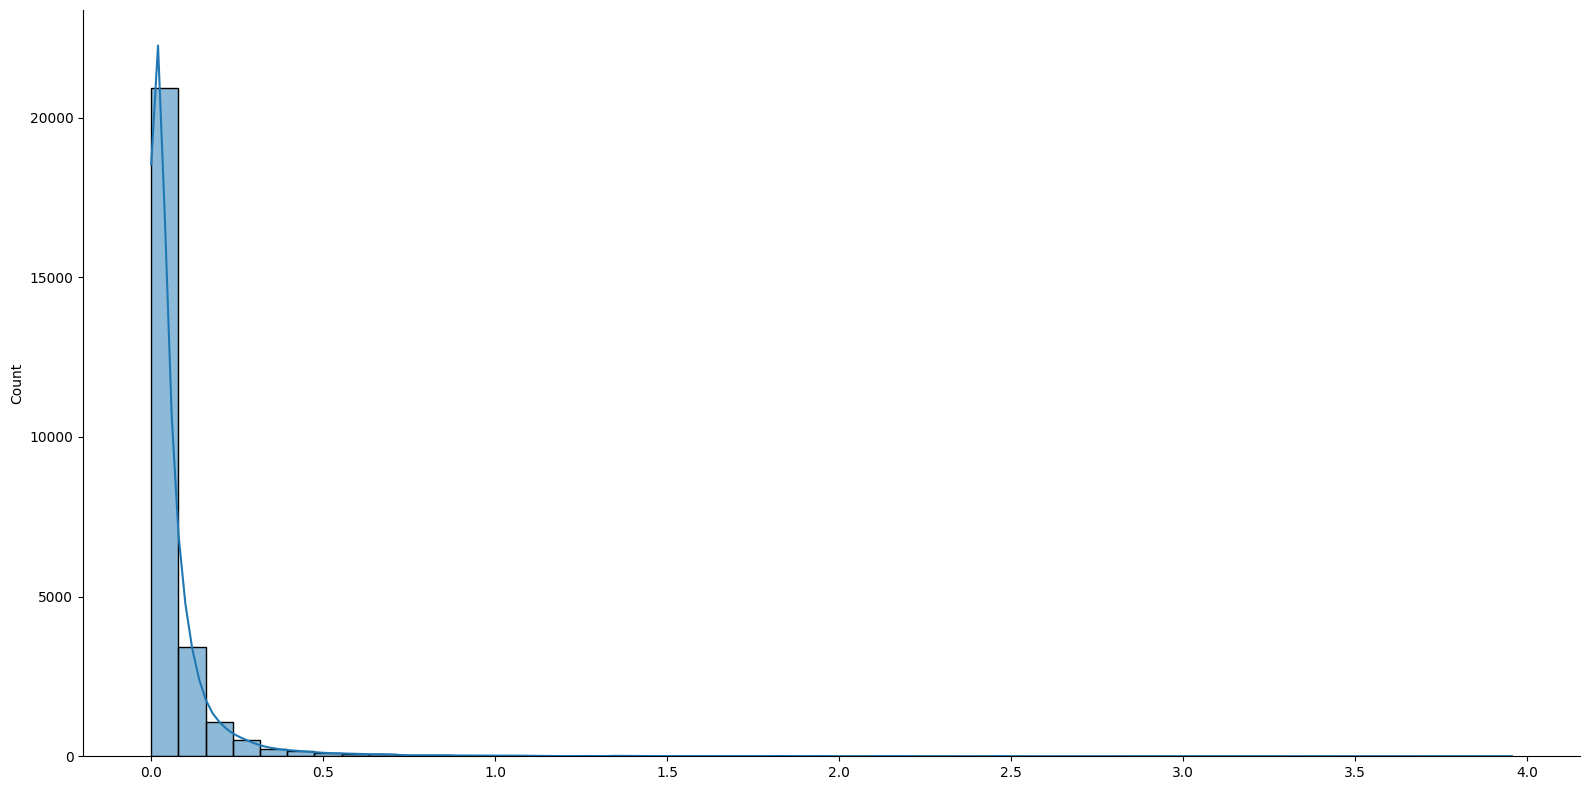

In [26]:
import seaborn as sns
m_3sd = acc_val_errors.mean() + 3*acc_val_errors.std()
m_4sd = acc_val_errors.mean() + 4*acc_val_errors.std()
riq = np.percentile(acc_val_errors, 75) + 1.5 * (np.percentile(acc_val_errors, 75) - np.percentile(acc_val_errors, 25))
max_max = acc_val_errors.max()
sns.displot(acc_val_errors, bins = 50, kde = True, height = 8, aspect = 2);

In [17]:
errors = trainer.predict(anomaly_detector, dm)
results = []
for item in errors:
    results.extend(item.cpu().numpy())
# indices = []
# for item in errors:
#     indices.extend(item[1].cpu().numpy())

# indices = np.array(indices)
acc_errors = accumulate_sequences(results, len_ts = 268, n_ts = val_df.ts_id.nunique(), seq_len=10)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


A Jupyter Widget

In [18]:
acc_errors.shape, val_df.shape

((53600,), (53600, 5))

In [19]:
val_df["pred_loss"] = acc_errors
val_df.to_csv("../preds/preds_vanillaAE.csv", index = False)

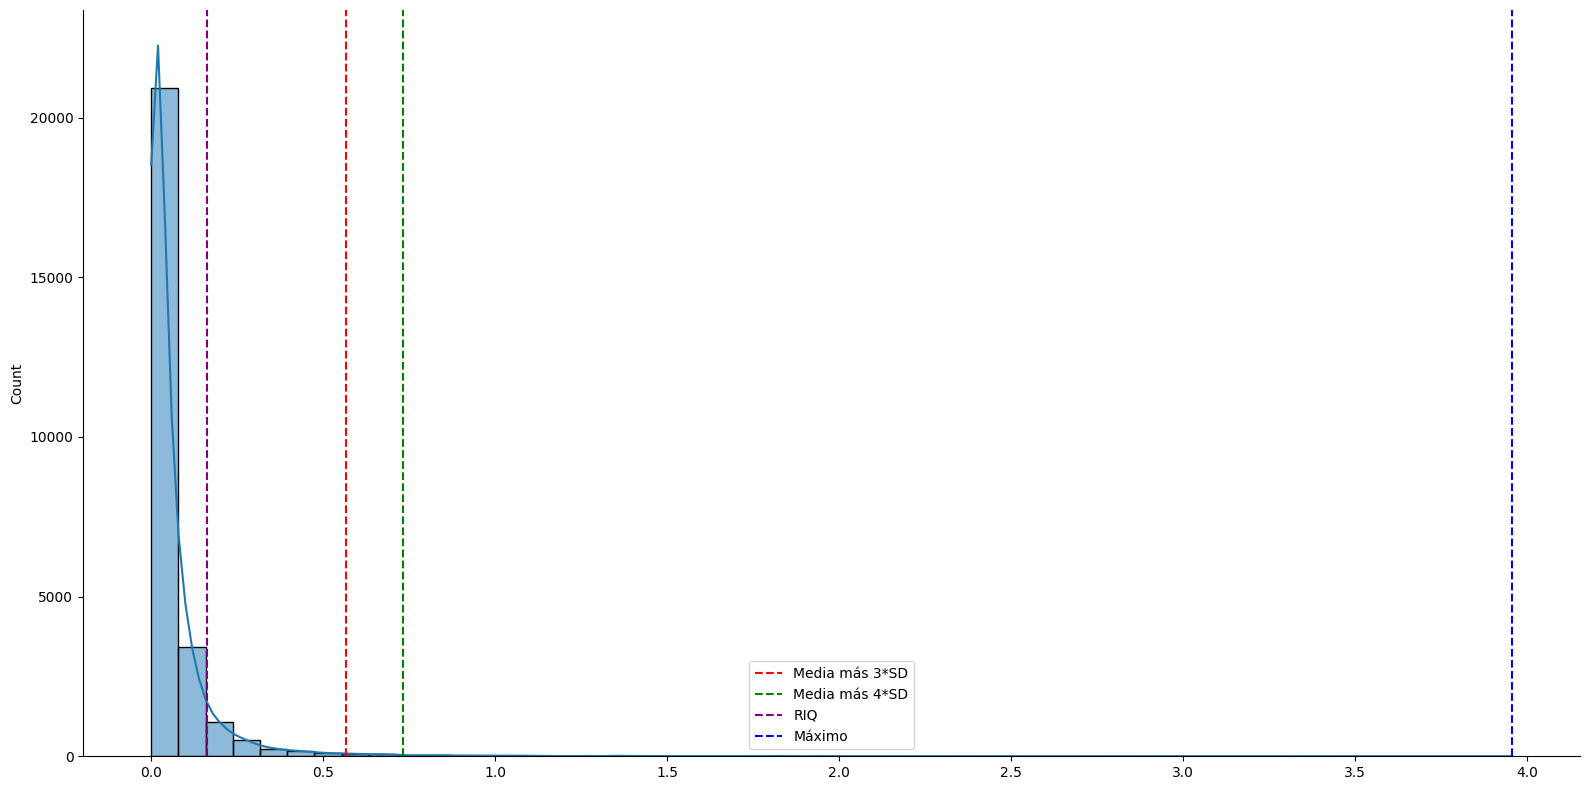

In [29]:
import matplotlib.pyplot as plt
sns.displot(acc_val_errors, bins = 50, kde = True, height = 8, aspect = 2)
plt.axvline(x = m_3sd, color = 'r', linestyle = '--', label = 'Media más 3*SD')
plt.axvline(x = m_4sd, color = 'green', linestyle = '--', label = 'Media más 4*SD')
plt.axvline(x = riq, color = 'purple', linestyle = '--', label = 'RIQ')
plt.axvline(x = max_max, color = 'blue', linestyle = '--', label = 'Máximo')
plt.legend();

In [31]:
def metrics(results):
    tp = results.loc["d"]
    fp = results.loc["nd"]
    tn = 100-results.loc["nd"]
    fn = 100-results.loc["d"]
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp /( tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return accuracy, precision, recall, f1

d     92
nd    89
Name: 1, dtype: int64


(0.515, 0.5082872928176796, 0.92, 0.6548042704626336)

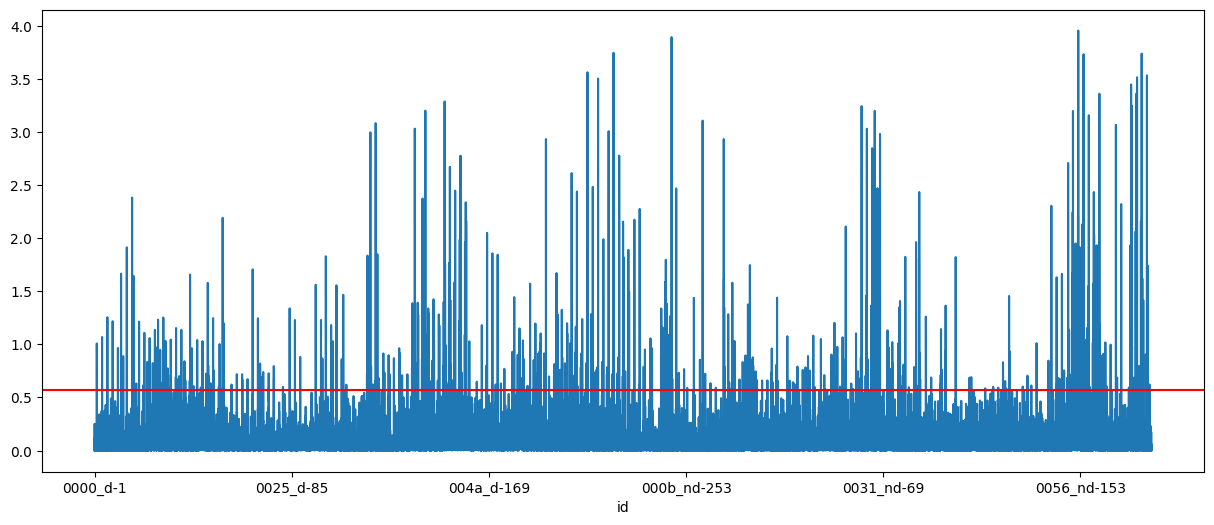

In [34]:
import matplotlib.pyplot as plt

def calculate_anomalies(acc_errors, threshold):
    errors = pd.Series(acc_errors, index = val_df.id)
    errors.plot(figsize = (15,6))
    plt.axhline(y = threshold, c = "red");
    print(errors.loc[lambda x: x> threshold].reset_index()["id"].str.split("-", expand=True)[0].drop_duplicates().str.split("_", expand=True)[1].value_counts())
    return errors

errors_m_3sd = calculate_anomalies(acc_errors, threshold = m_3sd)
metrics(errors_m_3sd.loc[lambda x: x> m_3sd].reset_index()["id"].str.split("-", expand=True)[0].drop_duplicates().str.split("_", expand=True)[1].value_counts())

d     82
nd    70
Name: 1, dtype: int64


(0.56, 0.5394736842105263, 0.82, 0.6507936507936507)

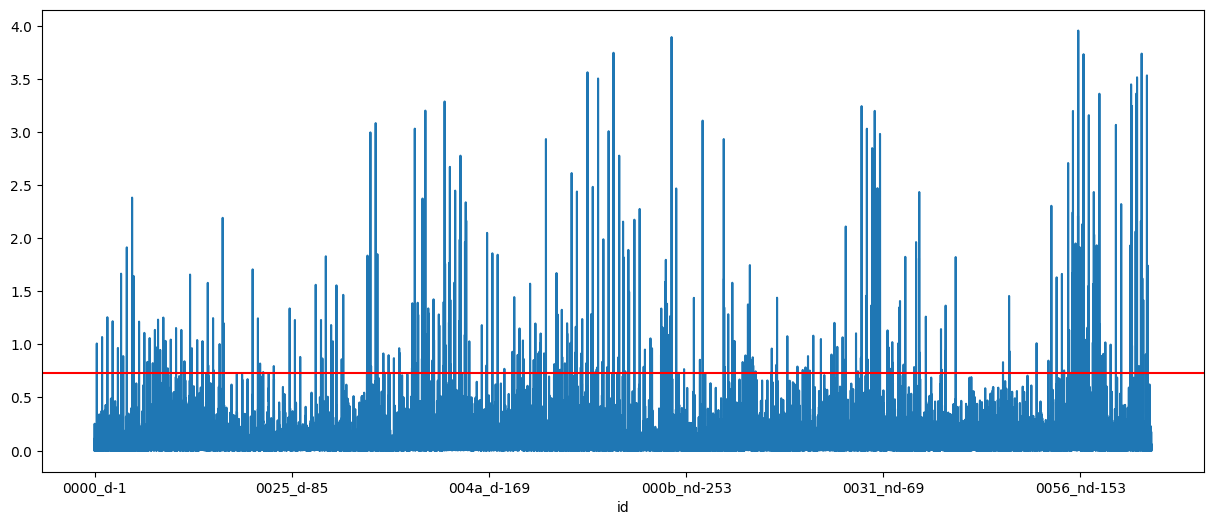

In [36]:
errors_m_4sd = calculate_anomalies(acc_errors, threshold = m_4sd)
metrics(errors_m_4sd.loc[lambda x: x> m_4sd].reset_index()["id"].str.split("-", expand=True)[0].drop_duplicates().str.split("_", expand=True)[1].value_counts())

d     100
nd    100
Name: 1, dtype: int64


(0.5, 0.5, 1.0, 0.6666666666666666)

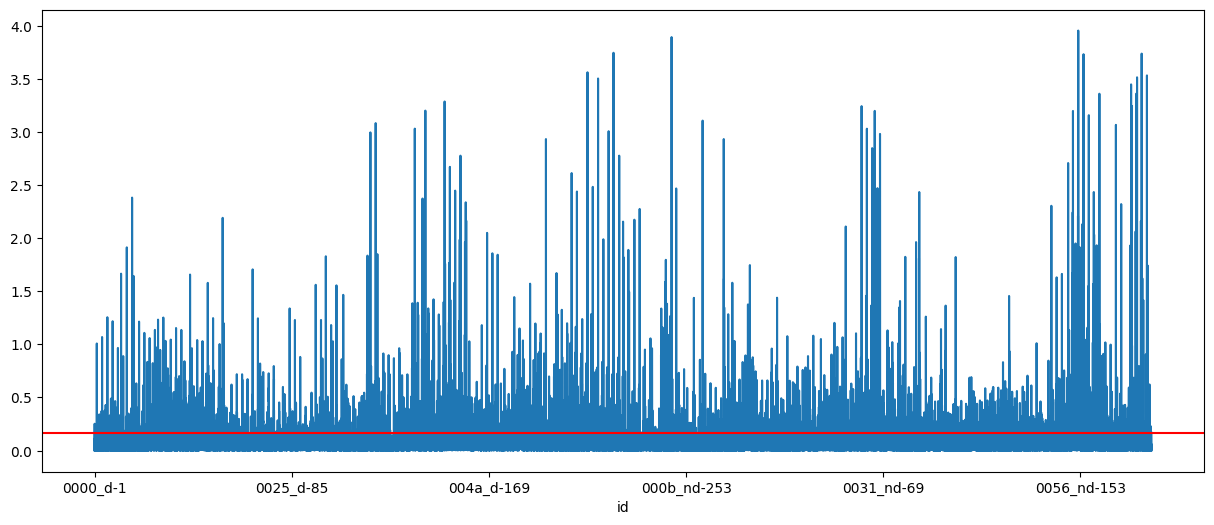

In [37]:
errors_riq = calculate_anomalies(acc_errors, threshold = riq)
metrics(errors_riq.loc[lambda x: x> riq].reset_index()["id"].str.split("-", expand=True)[0].drop_duplicates().str.split("_", expand=True)[1].value_counts())

In [ ]:
threshold = m_4sd

In [24]:
errors_df = errors.loc[lambda x: x > threshold].reset_index()
errors_df["ts_id"] = errors_df["id"].str.split("-", expand=True)[0]
errors_df.rename(columns = {0: "ndvi"}, inplace=True)
errors_df


,id,ndvi,ts_id
0,0000_d-114,1.008637,0000_d
1,0001_d-114,1.069595,0001_d
2,0002_d-114,1.255899,0002_d
3,0003_d-114,1.218335,0003_d
4,0005_d-5,1.666188,0005_d
...,...,...,...
250,0062_nd-125,1.417668,0062_nd
251,0063_nd-42,1.064388,0063_nd
252,0063_nd-43,3.533462,0063_nd
253,0063_nd-77,1.250999,0063_nd


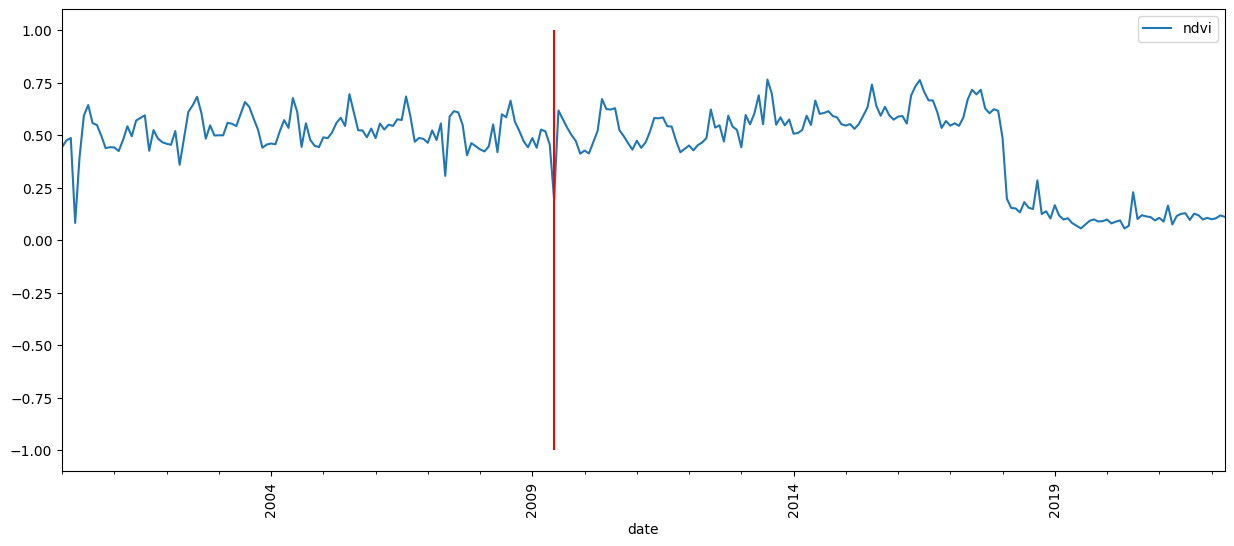

In [32]:
ide = "000b_d"
val_df.query(f'ts_id == "{ide}"').set_index("date")[["ndvi"]].plot(figsize = (15,6))
ides = errors_df.query(f'ts_id == "{ide}"').id.tolist()
dates = val_df.query("id in @ides").date.tolist()
plt.vlines(x = dates, ymin = -1, ymax = 1, color = "red")
plt.xticks(rotation=90);

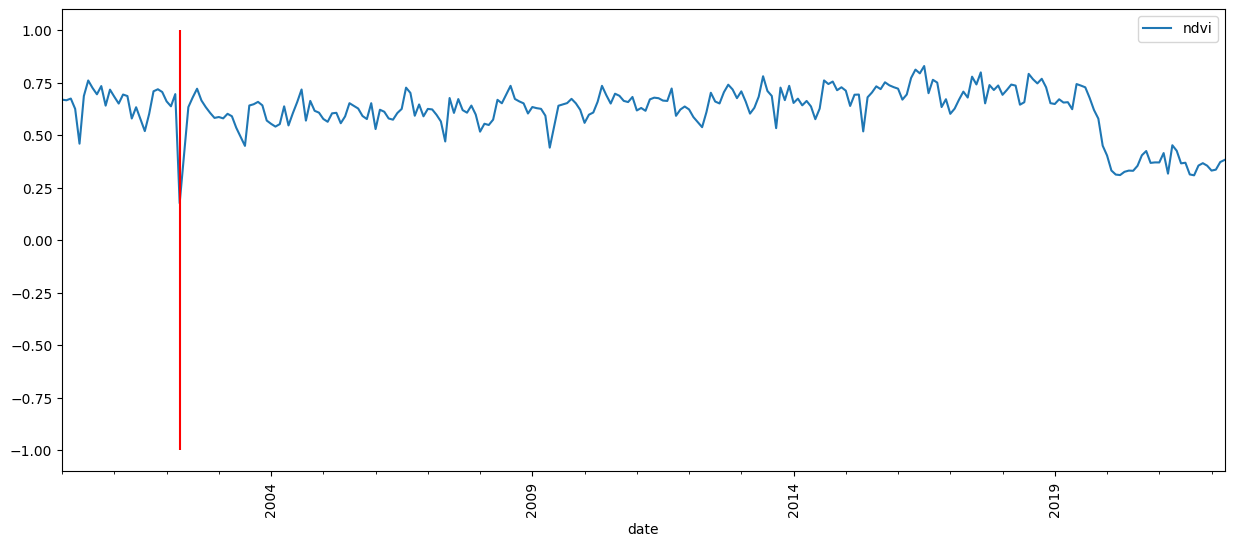

In [29]:
ide = "0006_d"
val_df.query(f'ts_id == "{ide}"').set_index("date")[["ndvi"]].plot(figsize = (15,6))
ides = errors_df.query(f'ts_id == "{ide}"').id.tolist()
dates = val_df.query("id in @ides").date.tolist()
plt.vlines(x = dates, ymin = -1, ymax = 1, color = "red")
plt.xticks(rotation=90);


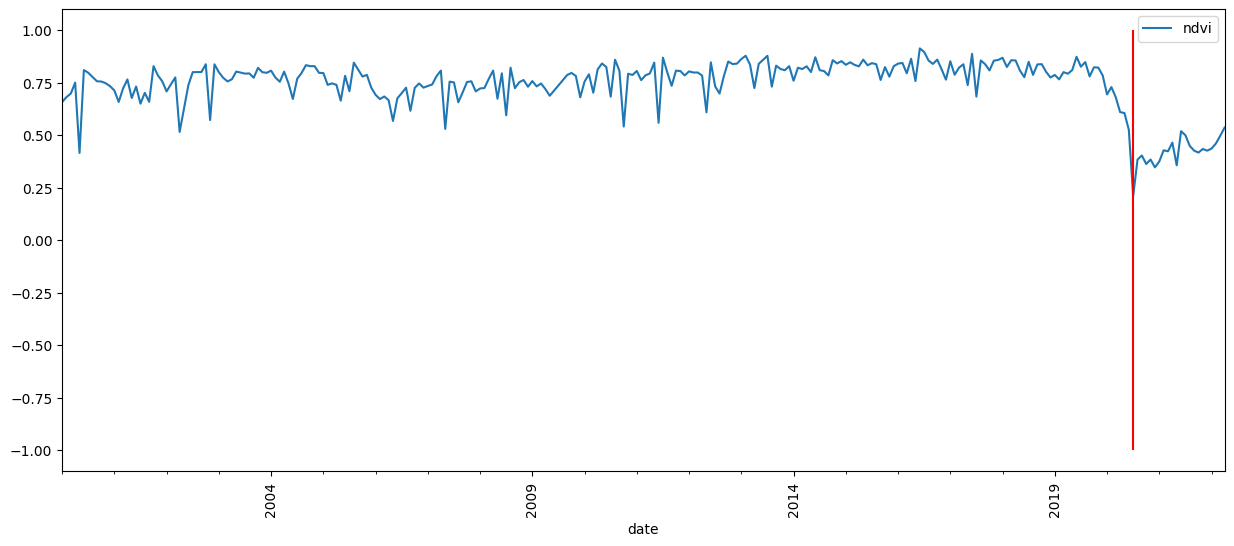

In [28]:
ide = "0025_d"
val_df.query(f'ts_id == "{ide}"').set_index("date")[["ndvi"]].plot(figsize = (15,6))
ides = errors_df.query(f'ts_id == "{ide}"').id.tolist()
dates = val_df.query("id in @ides").date.tolist()
plt.vlines(x = dates, ymin = -1, ymax = 1, color = "red")
plt.xticks(rotation=90);

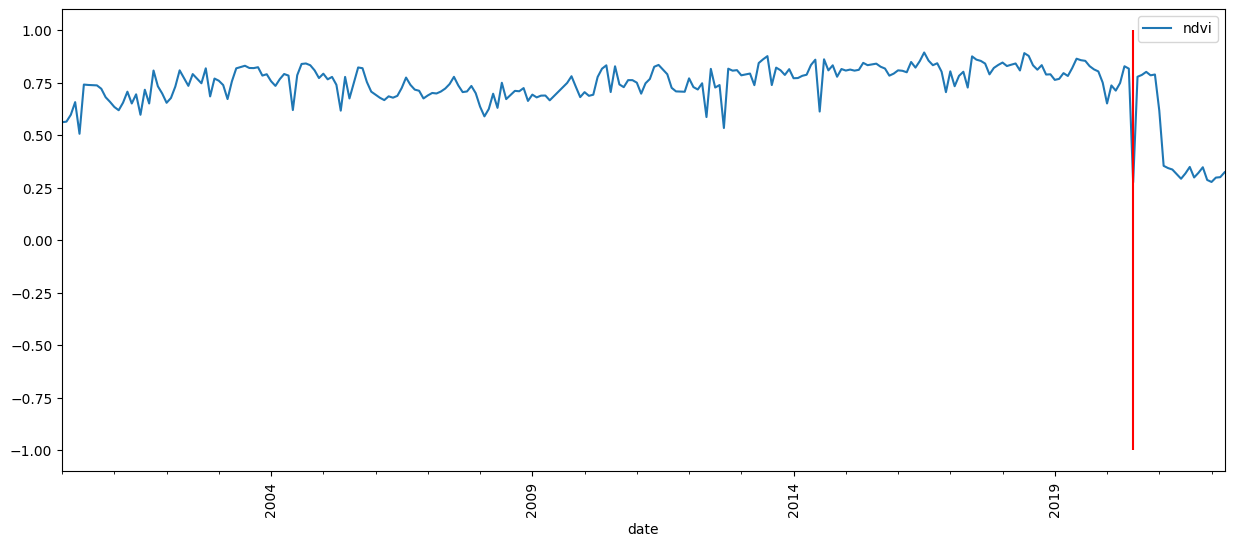

In [33]:
ide = "001d_d"
val_df.query(f'ts_id == "{ide}"').set_index("date")[["ndvi"]].plot(figsize = (15,6))
ides = errors_df.query(f'ts_id == "{ide}"').id.tolist()
dates = val_df.query("id in @ides").date.tolist()
plt.vlines(x = dates, ymin = -1, ymax = 1, color = "red")
plt.xticks(rotation=90);

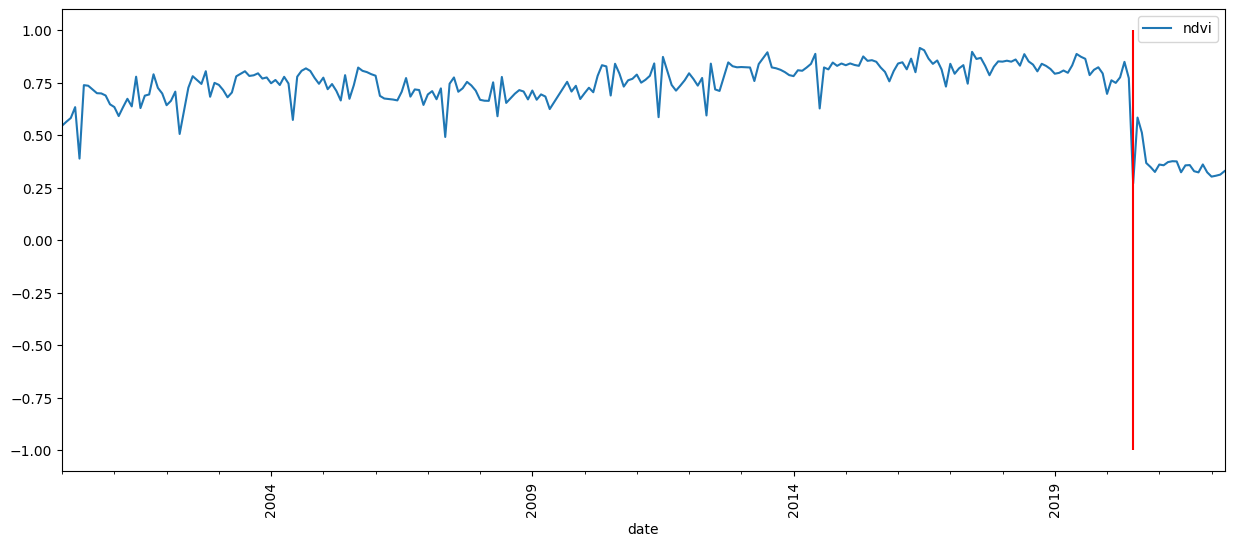

In [37]:
ide = "001e_d"
val_df.query(f'ts_id == "{ide}"').set_index("date")[["ndvi"]].plot(figsize = (15,6))
ides = errors_df.query(f'ts_id == "{ide}"').id.tolist()
dates = val_df.query("id in @ides").date.tolist()
plt.vlines(x = dates, ymin = -1, ymax = 1, color = "red")
plt.xticks(rotation=90);

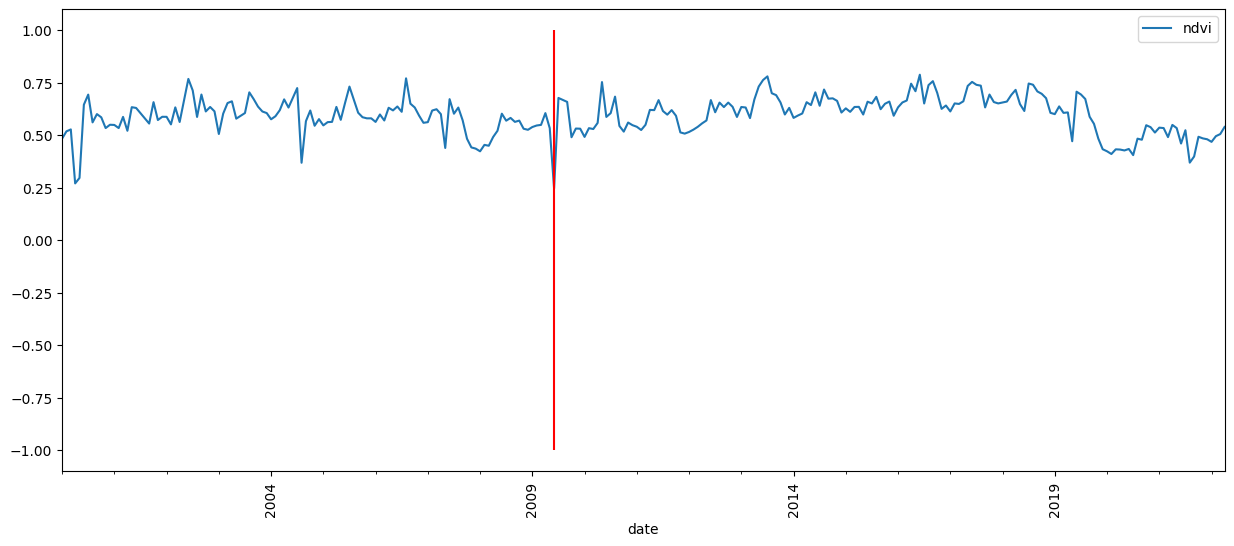

In [38]:
ide = "0009_d"
val_df.query(f'ts_id == "{ide}"').set_index("date")[["ndvi"]].plot(figsize = (15,6))
ides = errors_df.query(f'ts_id == "{ide}"').id.tolist()
dates = val_df.query("id in @ides").date.tolist()
plt.vlines(x = dates, ymin = -1, ymax = 1, color = "red")
plt.xticks(rotation=90);

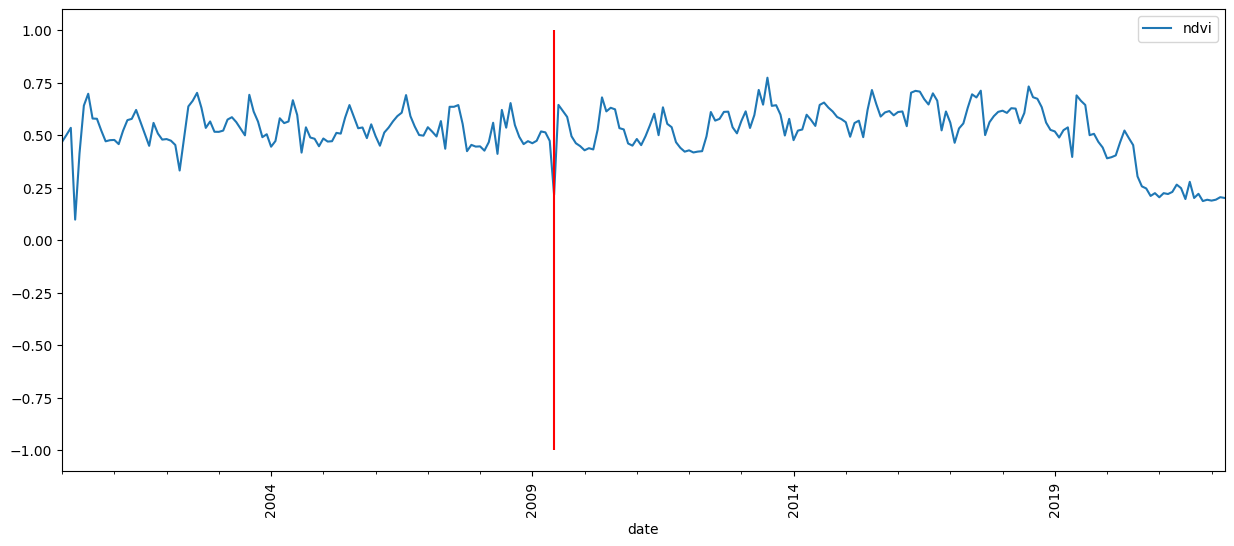

In [39]:
ide = "000a_d"
val_df.query(f'ts_id == "{ide}"').set_index("date")[["ndvi"]].plot(figsize = (15,6))
ides = errors_df.query(f'ts_id == "{ide}"').id.tolist()
dates = val_df.query("id in @ides").date.tolist()
plt.vlines(x = dates, ymin = -1, ymax = 1, color = "red")
plt.xticks(rotation=90);

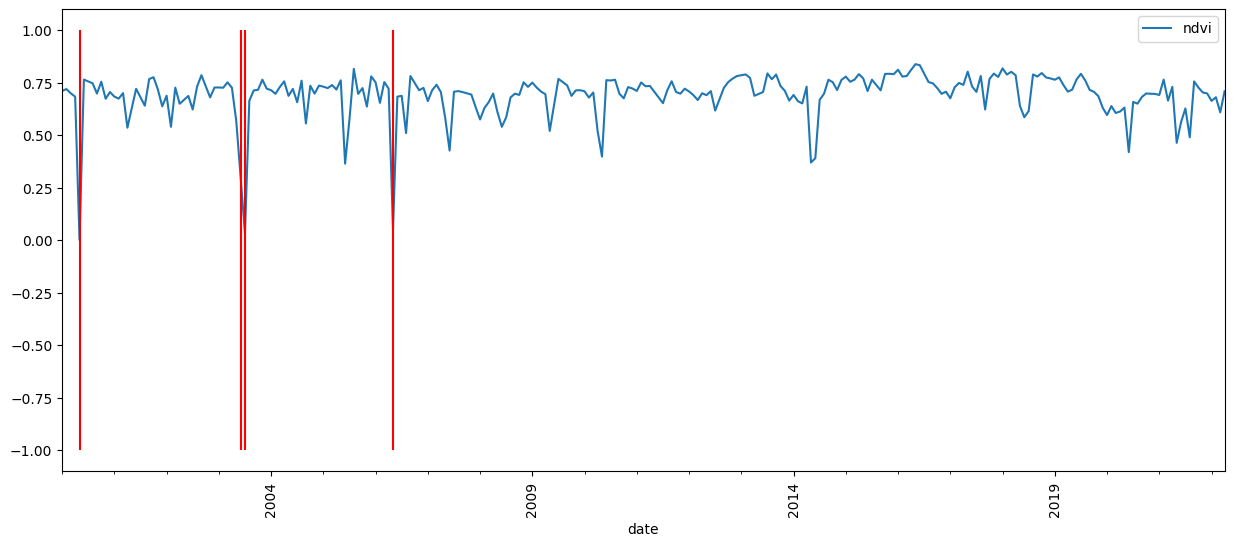

In [34]:
ide = "0061_nd"
val_df.query(f'ts_id == "{ide}"').set_index("date")[["ndvi"]].plot(figsize = (15,6))
ides = errors_df.query(f'ts_id == "{ide}"').id.tolist()
dates = val_df.query("id in @ides").date.tolist()
plt.vlines(x = dates, ymin = -1, ymax = 1, color = "red")
plt.xticks(rotation=90);

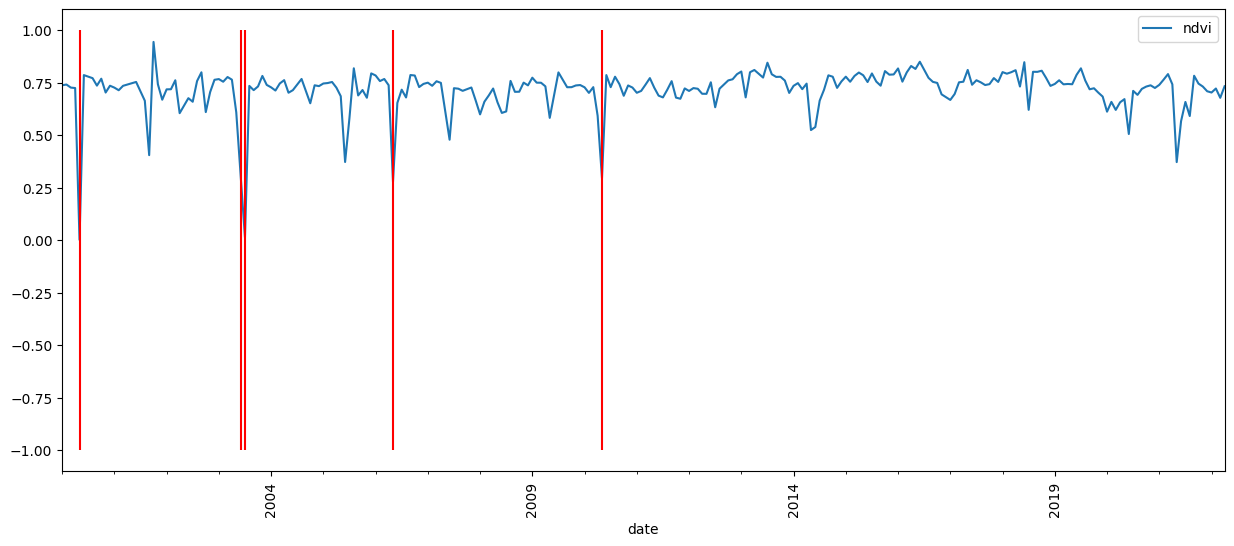

In [40]:
ide = "0062_nd"
val_df.query(f'ts_id == "{ide}"').set_index("date")[["ndvi"]].plot(figsize = (15,6))
ides = errors_df.query(f'ts_id == "{ide}"').id.tolist()
dates = val_df.query("id in @ides").date.tolist()
plt.vlines(x = dates, ymin = -1, ymax = 1, color = "red")
plt.xticks(rotation=90);

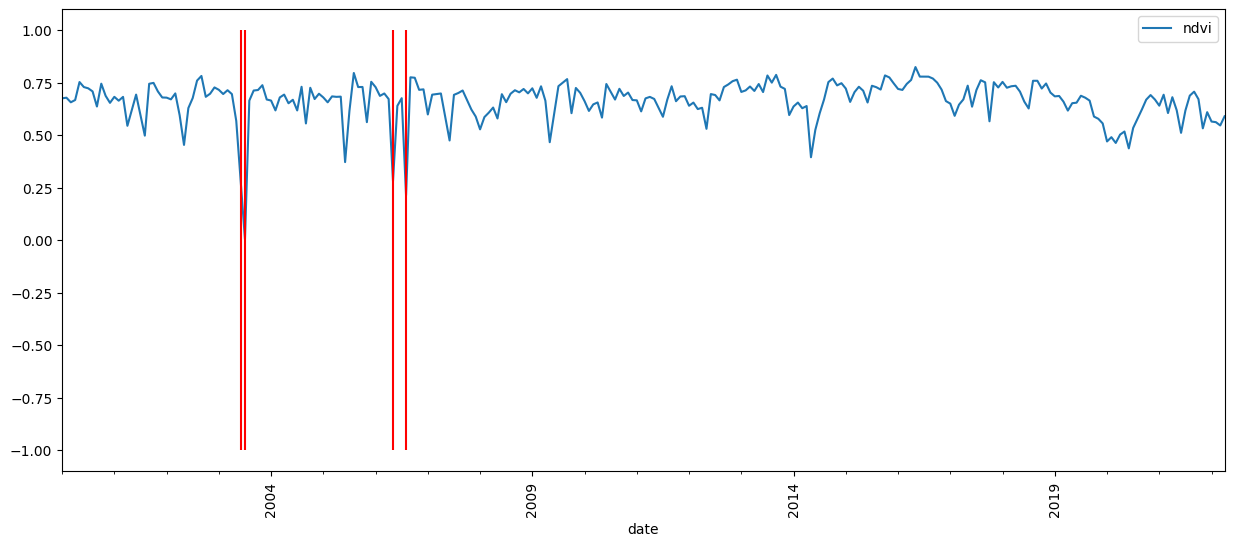

In [31]:
ide = "0063_nd"
val_df.query(f'ts_id == "{ide}"').set_index("date")[["ndvi"]].plot(figsize = (15,6))
ides = errors_df.query(f'ts_id == "{ide}"').id.tolist()
dates = val_df.query("id in @ides").date.tolist()
plt.vlines(x = dates, ymin = -1, ymax = 1, color = "red")
plt.xticks(rotation=90);